## 1. Setup and Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from prove_function import plot_true_vs_estimated_trajectories

# Import acoustic model functions
from acoustic_function import (
    initialize_acoustic_model,
    simulate_trajectory,
    compute_observation_jacobian,
    observation_model,
    state_transition
)

# Import PFPF class
from pfpf import PFPF

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.20.0
GPU available: False


## 2. Initialize Acoustic Model

In [2]:
# Initialize acoustic model with default parameters (4 targets, 25 sensors)
model_params = initialize_acoustic_model(n_targets=4)

print(f"Configuration:")
print(f"  Targets: {model_params['n_targets']}")
print(f"  Sensors: {model_params['n_sensors']} (5×5 grid)")
print(f"  State dimension: {model_params['state_dim']}")
print(f"  Surveillance area: {model_params['sim_area_size']}m × {model_params['sim_area_size']}m")

print(f"  Amplitude (Ψ): {model_params['amplitude'].numpy()}")
print(f"  Measurement noise std: {model_params['measurement_noise_std']}")

Configuration:
  Targets: 4
  Sensors: 25 (5×5 grid)
  State dimension: 16
  Surveillance area: 40.0m × 40.0m
  Amplitude (Ψ): 10.0
  Measurement noise std: 0.1


## 3. Generate Ground Truth Data

In [ ]:
# Generate ground truth trajectory and measurements
T = 20  # Number of time steps
print(f"Generating {T} time steps of data...")
ground_truth, measurements = simulate_trajectory(model_params, T, keep_in_bounds=True)


Generating 30 time steps of data...


# In the run function

In [4]:
pfpf_filter = PFPF(
    observation_jacobian=compute_observation_jacobian,
    observation_model=observation_model,
    state_transition=state_transition,
    n_particle=500,
    n_lambda=29,
    lambda_ratio=1.2,
    use_local=False,
    use_ekf=False,
    resample_threshold=0.5,
    verbose=True
)

In [5]:
T = tf.shape(measurements)[1].numpy()
_, _ = pfpf_filter.initialize(model_params)
estimates_list = []
particles_list = []
covariances_list = []
t = 0
z_t = tf.expand_dims(measurements[:, t], 1)
measurement = z_t
if len(measurement.shape) == 1:
    measurement = tf.expand_dims(measurement, 1)

x_est_prev = tf.expand_dims(pfpf_filter.M, 1) if len(pfpf_filter.M.shape) == 1 else pfpf_filter.M

pfpf_filter.particles_pred = pfpf_filter._propagate_particles(pfpf_filter.particles, model_params)
pfpf_filter.particles_pred_deterministic = pfpf_filter._propagate_particles_deterministic(
    pfpf_filter.particles, model_params
)

pfpf_filter.P_pred = pfpf_filter._estimate_covariance(pfpf_filter.particles_pred, model_params)
pfpf_filter.mu_0 = pfpf_filter.state_transition(x_est_prev, model_params, no_noise=True)

  Initialized uniform particle weights
  Initialized PFPF state variables


In [6]:
from prove_function import (
    particle_estimate,
    log_proposal_density,
    log_process_density,
    log_likehood_density,
    multinomial_resample
)

In [7]:
# pfpf_filter.particles_previous = pfpf_filter.particles
# pfpf_filter.particles = pfpf_filter.particles_pred

# # Step 4: Update auxiliary trajectory for linearization (vg['xp_auxiliary_individual'])
# # For EDH, this is the same as mu_0 (global linearization point)
# mean_estimate, _ = particle_estimate(pfpf_filter.log_weights, pfpf_filter.particles)
# pfpf_filter.auxiliary_trajectory = mean_estimate
# pfpf_filter.particles_mean = mean_estimate

In [8]:
# P_pred = pfpf_filter.P_pred

# log_weights = pfpf_filter.log_weights
# # Initialize auxiliary trajectory for global linearization
# eta_bar = tf.expand_dims(pfpf_filter.auxiliary_trajectory, 1) if len(pfpf_filter.auxiliary_trajectory.shape) == 1 else pfpf_filter.auxiliary_trajectory
# eta_bar_mu_0 = tf.expand_dims(pfpf_filter.mu_0, 1) if len(pfpf_filter.mu_0.shape) == 1 else pfpf_filter.M



In [9]:
# for j in range(pfpf_filter.n_lambda):
#     # Algorithm Line 12: Set λ = λ + ε_j
#     epsilon_j = pfpf_filter.lambda_steps[j]   # Step size
#     lambda_j = pfpf_filter.lambda_values[j]   # Current lambda value
    
#     # Algorithm Line 13: Compute A, b ONCE at global mean η̄
#     A, b = pfpf_filter._compute_flow_parameters(eta_bar, eta_bar_mu_0, P_pred, measurement,
#                                     lambda_j, model_params)
    
#     # Algorithm Line 14: Migrate η̄
#     slope_bar = tf.linalg.matvec(A, tf.squeeze(eta_bar)) + b
#     eta_bar = eta_bar + epsilon_j * tf.expand_dims(slope_bar, 1)
#     # print('herehere')
#     # Algorithm Line 14: Migrate η̄
#     slope_bar = tf.linalg.matvec(A, pfpf_filter.particles_mean) + b # It could be wrong even if it match the orginal matlab code
#     eta_bar = eta_bar + epsilon_j * tf.expand_dims(slope_bar, 1)

#     # Algorithm Lines 15-17: Migrate all particles using the same A, b
#     slopes = tf.matmul(A,  tf.squeeze(pfpf_filter.particles)) + tf.expand_dims(b, 1)
#     pfpf_filter.particles = pfpf_filter.particles + epsilon_j * slopes

#     particles_mean, _ = particle_estimate(log_weights, pfpf_filter.particles)
#     pfpf_filter.particles_mean = particles_mean

In [10]:
#  tf.squeeze(pfpf_filter.particles_mean)

In [11]:
# log_jacobian_det_sum = 0.0  # Can be computed for local linearization
# weights, log_weights = pfpf_filter._update_weights(
#     pfpf_filter.particles,
#     pfpf_filter.particles_pred,
#     pfpf_filter.particles_pred_deterministic,
#     measurement,
#     log_jacobian_det_sum,
#     model_params
# )

In [12]:
# mean_estimate, _ = particle_estimate(log_weights, pfpf_filter.particles)

In [13]:
# pfpf_filter.particles_mean = mean_estimate

In [14]:
# P_updated = pfpf_filter._estimate_covariance(pfpf_filter.particles, model_params)

In [15]:
# particles_resampled, weights_resampled, log_weights_resampled, N_eff = pfpf_filter._resample(
#     pfpf_filter.particles, weights
# )


In [16]:
# pfpf_filter.particles = particles_resampled
# pfpf_filter.weights = weights_resampled
# pfpf_filter.log_weights = log_weights_resampled
# pfpf_filter.particles_mean = mean_estimate
# pfpf_filter.P = P_updated
# pfpf_filter.M = mean_estimate

# Re-checking everything

## 4. Create PFPF Filter

The PFPF class encapsulates all filter state and behavior:

In [17]:
# Create PFPF filter instance
pfpf_filter = PFPF(
    observation_jacobian=compute_observation_jacobian,
    observation_model=observation_model,
    state_transition=state_transition,
    n_particle=500,
    n_lambda=29,
    lambda_ratio=1.2,
    use_local=False,
    use_ekf=False,
    resample_threshold=0.5,
    verbose=True
)


## 5. Run PFPF Filter

In [18]:
estimates, particles_all, covariances_all = pfpf_filter.run(measurements, model_params)


Running PFPF Filter:
  Particles: 500
  Lambda steps: 29
  Lambda ratio: 1.2
  Linearization: Global (EDH)
  EKF Covariance: Disabled
  Resample threshold: 0.5
  Time steps: 30
  Initialized uniform particle weights
  Initialized PFPF state variables

Processing time steps...
t 0
eta_bar tf.Tensor(
[[ 1.1855570e+01]
 [ 5.7562599e+00]
 [ 5.1459558e-02]
 [-5.1168159e-02]
 [ 3.2210762e+01]
 [ 3.1569237e+01]
 [ 5.1558781e-03]
 [ 3.5268974e-02]
 [ 1.9862173e+01]
 [ 1.2630832e+01]
 [-9.7620934e-02]
 [ 3.2455459e-02]
 [ 1.5014970e+01]
 [ 3.4980980e+01]
 [-7.7111181e-04]
 [-2.2581093e-02]], shape=(16, 1), dtype=float32)
tf.Tensor(
[[ 1.1877261e+01]
 [ 5.7967420e+00]
 [ 5.4062638e-02]
 [-3.4164254e-02]
 [ 3.2260567e+01]
 [ 3.1781975e+01]
 [ 5.8448776e-03]
 [ 4.5670409e-02]
 [ 1.9998819e+01]
 [ 1.2535842e+01]
 [-9.1508411e-02]
 [ 2.7138624e-02]
 [ 1.5121057e+01]
 [ 3.5014313e+01]
 [ 6.8512755e-03]
 [-1.6210696e-02]], shape=(16, 1), dtype=float32)
herehere
herehere
herehere
herehere
herehere
her

## 6. Evaluate Performance

In [19]:
def compute_position_error(estimates, ground_truth, n_targets):
    errors = []
    for i in range(n_targets):
        x_idx = i * 4
        y_idx = i * 4 + 1
        x_err = estimates[x_idx, :] - ground_truth[x_idx, :]
        y_err = estimates[y_idx, :] - ground_truth[y_idx, :]
        error = tf.sqrt(x_err**2 + y_err**2)
        errors.append(error)
    errors = tf.stack(errors, axis=0)
    mean_error = tf.reduce_mean(errors, axis=0)
    return errors, mean_error

errors, mean_error = compute_position_error(estimates, ground_truth[:, 1:], model_params['n_targets'])
rmse = tf.sqrt(tf.reduce_mean((estimates - ground_truth[:, 1:])**2))

print("="*70)
print("PERFORMANCE RESULTS")
print("="*70)
print(f"Overall RMSE: {rmse.numpy():.4f} m")
print(f"Mean position error (final): {mean_error[-1].numpy():.4f} m")
print(f"Mean position error (average): {tf.reduce_mean(mean_error).numpy():.4f} m")
print("Per-target average errors:")
for i in range(model_params['n_targets']):
    print(f"  Target {i+1}: {tf.reduce_mean(errors[i]).numpy():.4f} m")
print("="*70)

PERFORMANCE RESULTS
Overall RMSE: 0.9564 m
Mean position error (final): 3.4499 m
Mean position error (average): 0.9636 m
Per-target average errors:
  Target 1: 0.6081 m
  Target 2: 0.4472 m
  Target 3: 1.3901 m
  Target 4: 1.4089 m


## 7. Access Filter State

In [20]:
print("Final filter state:")
print(f"  Particles: {pfpf_filter.particles.shape}")
print(f"  Weights sum: {tf.reduce_sum(pfpf_filter.weights).numpy():.6f}")
print(f"  Mean estimate: {pfpf_filter.particles_mean.shape}")
print(f"  Covariance P: {pfpf_filter.P.shape}")
print(" vg dictionary → PFPF class mapping:")
print(f"  vg['particles']   → self.particles")
print(f"  vg['logW']        → self.log_weights")
print(f"  vg['ml_weights']  → self.weights")
print(f"  vg['particles_m'] → self.particles_mean")

Final filter state:
  Particles: (16, 500)
  Weights sum: 1.000000
  Mean estimate: (16,)
  Covariance P: (16, 16)
 vg dictionary → PFPF class mapping:
  vg['particles']   → self.particles
  vg['logW']        → self.log_weights
  vg['ml_weights']  → self.weights
  vg['particles_m'] → self.particles_mean


## 8. Visualize Results

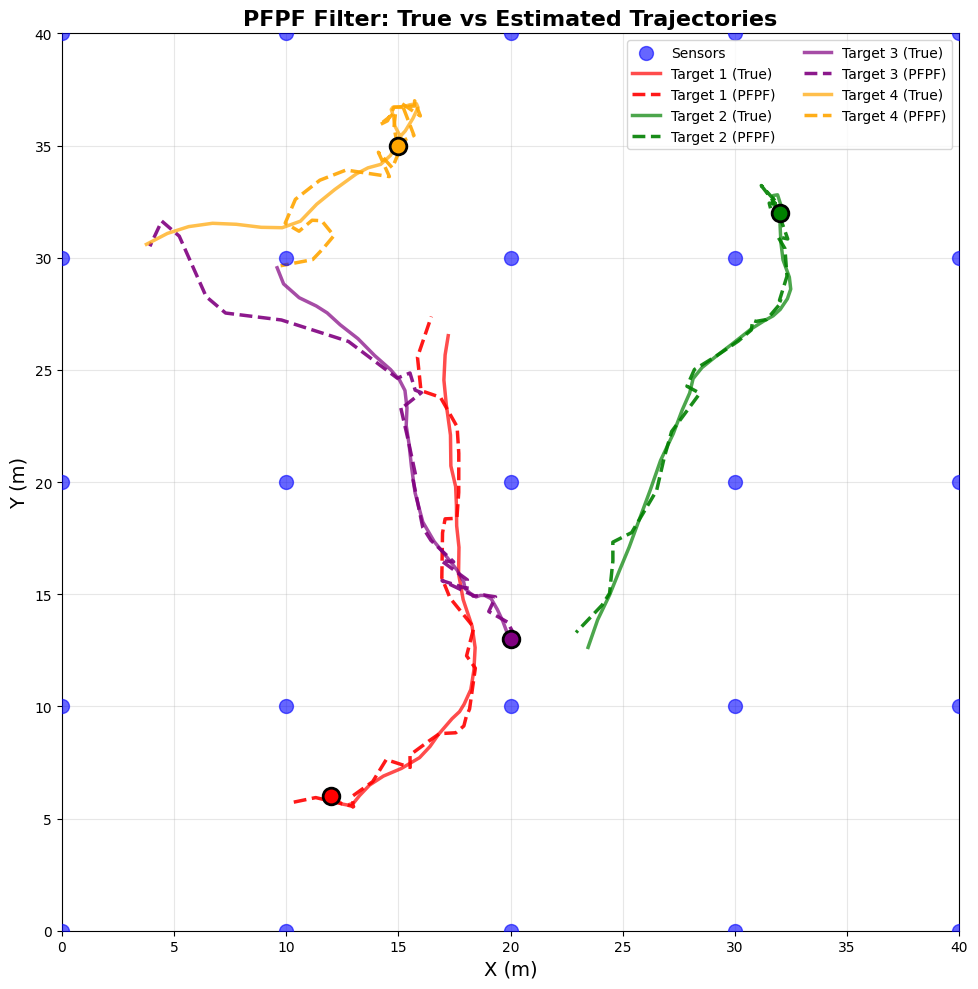

In [21]:
plot_true_vs_estimated_trajectories(
    model_params,
    ground_truth,
    estimates,
    title="PFPF Filter: True vs Estimated Trajectories",
    estimate_label="PFPF",
    figsize=(12, 10),
    colors=None
)